In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sxs
import qnmfits

In [2]:
h = sxs.load('SXS:BBH:0305/Lev/rhOverM', extrapolation_order=2)
h.t -= h.max_norm_time()

metadata = sxs.load('SXS:BBH:0305/Lev/metadata.json')
Mf = metadata.remnant_mass
chif = np.linalg.norm(metadata.remnant_dimensionless_spin)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


In [3]:
spherical_mode = (2,2)
qnms = [(2,2,n,1) for n in range(7+1)]
t0 = 0

best_fit = qnmfits.ringdown_fit(
    h,
    spherical_mode,
    qnms,
    Mf=Mf,
    chif=chif,
    t0=t0
)

print(best_fit['mismatch'])

3.0491547819977427e-07


In [4]:
clean_h22 = best_fit['model']
times = best_fit['times']

In [5]:
clean_h22_wm = qnmfits.to_WaveformModes(times, {(2,2):clean_h22}, ell_max=2)

In [6]:
best_fit = qnmfits.ringdown_fit(
    clean_h22_wm,
    spherical_mode,
    qnms,
    Mf=Mf,
    chif=chif,
    t0=t0
)

print(best_fit['mismatch'])

0.0


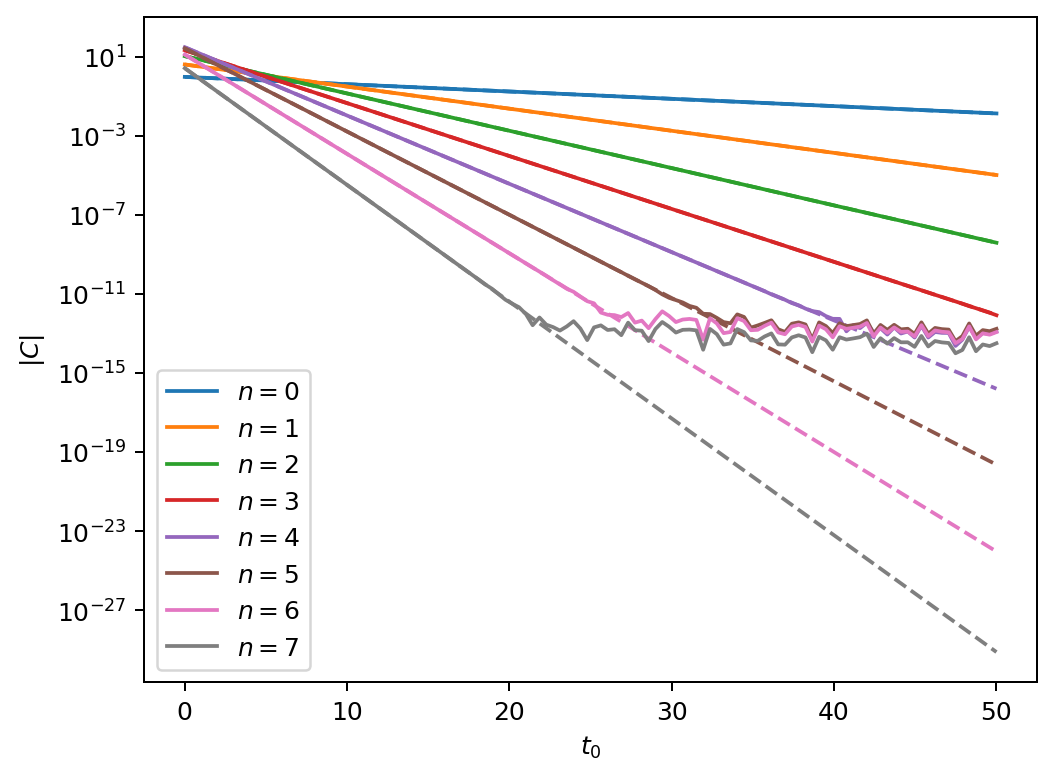

In [7]:
t0_array = np.linspace(0, 50, 120)

frequencies = qnmfits.qnm.omega_list(qnms, chif, Mf)

amp_list = []

for t0 in t0_array:
    
    best_fit = qnmfits.ringdown_fit(
        clean_h22_wm,
        spherical_mode,
        qnms,
        Mf=Mf,
        chif=chif,
        t0=t0
    )
    
    amp_list.append(best_fit['C'])
    
amp_array = np.array(amp_list)

fig, ax = plt.subplots(dpi=180)
ax.set_yscale('log')

for n in range(len(qnms)):

    ax.plot(t0_array, abs(amp_array[:,n]), label=f'$n={n}$')

    # The expected amplitude decay from the QNM frequency
    tau = -1/np.imag(frequencies[n])
    expected_amp = abs(amp_array[:,n][0])*np.exp(-t0_array/tau)

    ax.plot(t0_array, expected_amp, c=f'C{n}', ls='--')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$|C|$')

_ = ax.legend()